In [30]:
%pylab inline --no-import-all
matplotlib.style.use('ggplot')
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
np.random.seed(7)

Populating the interactive namespace from numpy and matplotlib


# Hoeffding Inequality

In [2]:
def coins_experiments(n_coins, n_flips, n_experiments):
    
    flips = np.random.randint(0, 2, size=(n_experiments, n_coins, n_flips), dtype=bool)
    frequencies = np.apply_along_axis(arr=flips, axis=2, func1d=np.mean)

    fr_1 = frequencies[:, 0]
    fr_min = np.min(frequencies, axis=1)
    fr_rand = np.apply_along_axis(func1d=np.random.choice, arr=frequencies, axis=1)
    
    return np.mean(fr_1), np.mean(fr_min), np.mean(fr_rand)

Benchmark a 1/100 of experiment to approximate full experiment time requirements

In [5]:
%time Parallel(n_jobs=4)(delayed(coins_experiments)(1000, 10, 250) for i in range(4))
pass

CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 3.24 s


So full experiment will take about 100x time to run.
Be careful as for sake of computations speed it takes about 1GB of memory just for raw data plus ~1GB for intermediate steps.

In [6]:
nus_list = np.array( Parallel(n_jobs=4)(delayed(coins_experiments)(1000, 10, 25000) for i in range(4)) )
nu_1, nu_min, nu_rand = np.mean(nus_list, axis=0)
print("nu_1 is %f" % nu_1)
print("nu_min is %f" % nu_min)
print("nu_rand is %f" % nu_rand)

nu_1 is 0.502732
nu_min is 0.037836
nu_rand is 0.499608


# Linear regression

In [70]:
from linear_regression import LinearRegression as LR
from perceptron import Perceptron

In [71]:
lr = LR()

In [72]:
X = np.random.normal(size=(100, 1))
y = np.random.normal(loc=0.4, size=(100, 1)) - 3*X
lr.fit(X, y, method='closed')

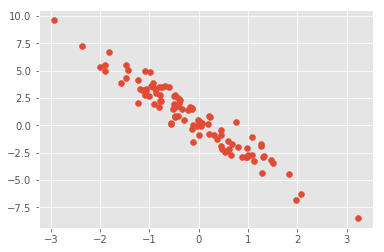

In [73]:
plt.scatter(X, y)

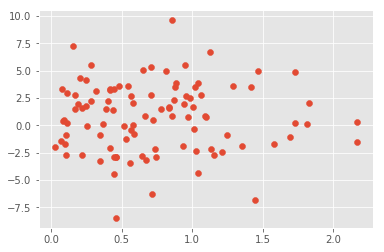

In [74]:
plt.scatter(np.abs(lr.predict(X) - y), y)

In [75]:
lr.r_squared(X, y)

array([ 0.92059084])

In [89]:
def create_dataset(n, w, f=None):
    if f is None:
        # n: sample size
        # w: boundary line coefs (intercept, slope1, slope2)
        wlen = np.sqrt(np.sum(np.inner(w, w)))
        f = lambda x: np.sign(np.inner(w/wlen, np.concatenate(([1], x))))
    X = np.random.uniform(-1, 1, size=(n, 2))
    y = np.apply_along_axis(f, 1, X)
    return X, y


def line(coefs):
    if coefs[2] > 0:
        x1 = np.array([-1, 1])
        x2 = (lambda x: -(coefs[0] + coefs[1] * x) / coefs[2])(x1)
    elif coefs[1] > 0:
        x2 = np.array([-1, 1])
        x1 = (lambda x: -(coefs[0] + coefs[2] * x) / coefs[1])(x2)
    else:
        x1 = [-1, 1]
        x2 = [-1,-1]
    return (x1, x2)

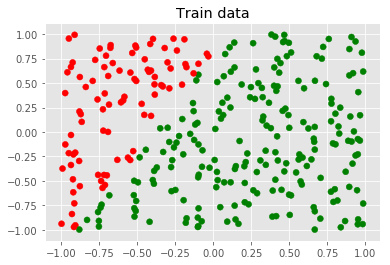

In [90]:
true_coefs = [1, 2.5, -1.25]
X, y = create_dataset(300, true_coefs)

plt.scatter(X[:, 0], X[:, 1], c=np.where(y>0, 'green', 'red'))
plt.title("Train data")

In [91]:
lr.fit(X, y, method='closed')
testX, testY = create_dataset(10000, true_coefs)
yhat = lr.predict(X)
yhat2 = lr.predict(testX)

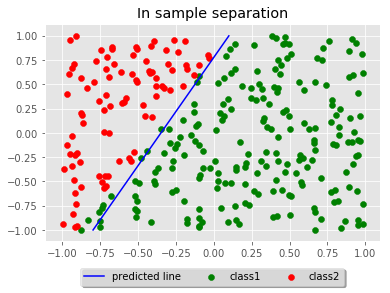

In [92]:
X1 = X[y > 0]
X2 = X[y < 0]
plt.scatter(X1[:, 0], X1[:, 1], c='green', label='class1')
plt.scatter(X2[:, 0], X2[:, 1], c='red', label='class2')

plt.plot(*line(lr._coef), c='blue', label='predicted line')
plt.title("In sample separation")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

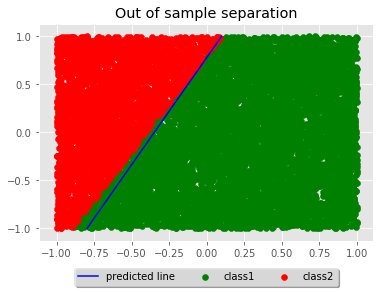

In [93]:
X1 = testX[testY > 0]
X2 = testX[testY < 0]
plt.scatter(X1[:, 0], X1[:, 1], c='green', label='class1')
plt.scatter(X2[:, 0], X2[:, 1], c='red', label='class2')

plt.plot(*line(lr._coef), c='blue', label='predicted line')
plt.title("Out of sample separation")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

In [94]:
print("in-sample error: %f" % np.mean(np.sign(yhat).reshape((-1)) != y))
print("out-of-sample error: %f" % np.mean(np.sign(yhat2).reshape((-1)) != testY))

in-sample error: 0.033333
out-of-sample error: 0.025900


In [95]:
sum_of_errors = 0
sum_of_errors2 = 0

for _ in tqdm(range(1000), desc='progress'):
    lr = LR()
    true_coefs = np.random.uniform(low=-5, high=5, size=(3))
    X, y = create_dataset(100, true_coefs)
    testX, testY = create_dataset(1000, true_coefs)
    lr.fit(X, y, method='closed')
    yhat = lr.predict(X)
    yhat2 = lr.predict(testX)
    error = np.mean(np.sign(yhat).reshape((-1)) != y)
    error2 = np.mean(np.sign(yhat2).reshape((-1)) != testY)
    sum_of_errors += error
    sum_of_errors2 += error2
    
print("average in-sample error: %f" % (sum_of_errors / 1000))
print("average out-of-sample error: %f" % (sum_of_errors2 / 1000))


average in-sample error: 0.034920
average out-of-sample error: 0.041468


In [96]:
convergence_wo_init = 0
convergence_with_init = 0

np.random.seed(1)
for _ in tqdm(range(1000), desc='progress'):
    lr = LR()
    perceptron1 = Perceptron()
    perceptron2 = Perceptron()
    true_coefs = np.random.uniform(low=-5, high=5, size=(3))
    X, y = create_dataset(10, true_coefs)
    convergence_wo_init += perceptron1.fit(X, y)
    
    lr.fit(X, y, method='closed')
    convergence_with_init += perceptron2.fit(X, y, initial_weights=lr._coef.reshape((-1)))
    
print("average convergence from stratch: %f" % (convergence_wo_init / 1000))
print("average convergence with regression initializer: %f" % (convergence_with_init / 1000))


average convergence from stratch: 8.383000
average convergence with regression initializer: 3.393000


# Nonlinear Transformations

In [139]:
np.random.seed(6)
f = lambda x: np.sign(x[0]**2 + x[1]**2 - 0.6)
X, y = create_dataset(1000, None, f)

rand_index = np.random.permutation(1000)[:100]
y[rand_index] *= -1 # adding some noize

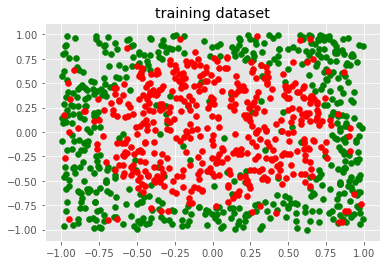

In [140]:
X1 = X[y > 0]
X2 = X[y < 0]
plt.scatter(X1[:, 0], X1[:, 1], c='green', label='class1')
plt.scatter(X2[:, 0], X2[:, 1], c='red', label='class2')
plt.title("training dataset")

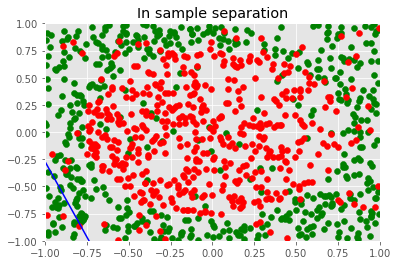

In [180]:
lr = LR()
lr.fit(X, y, method='closed')

X1 = X[y > 0]
X2 = X[y < 0]
plt.scatter(X1[:, 0], X1[:, 1], c='green', label='class1')
plt.scatter(X2[:, 0], X2[:, 1], c='red', label='class2')
plt.plot(*line(lr._coef), c='blue', label='predicted line')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("In sample separation")

In [181]:
yhat = lr.predict(X).reshape((-1))
err = np.sum(np.sign(yhat) != y) / 1000
print("In-sample error: %f" % err)

In-sample error: 0.500000


In [182]:
np.random.seed(None)
f = lambda x: np.sign(x[0]**2 + x[1]**2 - 0.6)
total_error = 0

for i in tqdm(range(1000)):
    X, y = create_dataset(1000, None, f)
    rand_index = np.random.permutation(1000)[:100]
    y[rand_index] *= -1 
    lr = LR()
    lr.fit(X, y, method='closed')
    yhat = lr.predict(X).reshape((-1))
    total_error += (np.sum(np.sign(yhat) != y) / 1000)
    
print("average in-sample error: %f" % (total_error / 1000))


average in-sample error: 0.503802


In [192]:
from polynomial_features import PolynomialFeatures

f = lambda x: np.sign(x[0]**2 + x[1]**2 - 0.6)
weights = np.zeros(6, dtype=float) # 6 features: 1 x1 x2 x1*x2 x1^2 x2^2
runs = 50

for _ in tqdm(range(runs)):
    X, y = create_dataset(1000, None, f)
    rand_index = np.random.permutation(1000)[:100]
    y[rand_index] *= -1 
    XX, names = PolynomialFeatures.get_features(X, 2, mix=True, names=["x1", "x2"],
                                           power_pattern=lambda f,p: "(%s^%d)" % (f, p),
                                           product_pattern=lambda f1,f2: f1 + "*" + f2)
    lr = LR()
    lr.fit(XX, y, method='closed')
    weights += lr._coef.reshape((-1))
    
    
avg_weights = (weights / runs)
names_ = ["1"] + names

print("Approximate weights: ")
for name, weight in zip(names_, avg_weights):
    print("  %s: %f" %(name, weight))


Approximate weights: 
  1: -0.995100
  x1: 0.010893
  x2: -0.000373
  (x1^2): 1.553038
  x1*x2: -0.022849
  (x2^2): 1.570698


In [194]:
runs = 1000

lr = LR()
lr._coef = avg_weights.reshape((-1, 1))

total_error = 0
for _ in tqdm(range(runs)):
    X, y = create_dataset(1000, None, f)
    rand_index = np.random.permutation(1000)[:100]
    y[rand_index] *= -1 
    
    XX, names = PolynomialFeatures.get_features(X, 2, mix=True)
    yhat = lr.predict(XX).reshape((-1))
    total_error += (np.sum(np.sign(yhat) != y) / 1000)

print("average out-of-sample error: %f" % (total_error / runs))


average out-of-sample error: 0.123199
